## Airline Ticket Dataset — Data Cleaning & Preparation
### 1. Load Data

We load the airline ticket dataset and create a working copy `air` to perform cleaning and feature engineering without modifying the original dataset.



In [ ]:
import pandas as pd

import matplotlib.pyplot as plt## Airline Ticket Dataset — Data Cleaning & Preparation



In [ ]:
airline = pd.read_excel("airline_ticket_dataset.xlsx")
air = airline.copy()

### 2. Inspect the Raw Dataset

We first examine the first few rows to understand the structure and what each observation looks like.
The dataset contains route-level observations across different **years** and **quarters**, with information on:

* route characteristics (city1, city2, distance)
* demand (passengers)
* ticket prices (fare, fare_lg, fare_low)
* market structure (large_ms, lf_ms)
* city-level aggregated metrics (e.g., TotalFaredPax_city1/city2)

In [2]:
air.head()

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,...,fare_lg,carrier_low,lf_ms,fare_low,TotalFaredPax_city1,TotalPerLFMkts_city1,TotalPerPrem_city1,TotalFaredPax_city2,TotalPerLFMkts_city2,TotalPerPrem_city2
0,2025,2,32467,31703,"Miami, FL (Metropolitan Area)","New York City, NY (Metropolitan Area)",1118,17955,208.52,B6,...,191.48,B6,0.2551,191.48,4.322090e+06,0.88590,-0.065800,2.978413e+06,0.821150,-0.032867
1,2025,2,32575,32457,"Los Angeles, CA (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",372,17310,157.68,WN,...,169.03,AS,0.1193,140.59,2.822942e+06,0.86508,-0.038060,3.284783e+06,0.880833,-0.051467
2,2025,2,32575,31703,"Los Angeles, CA (Metropolitan Area)","New York City, NY (Metropolitan Area)",2510,13648,430.38,DL,...,526.21,B6,0.2272,365.63,2.822942e+06,0.86508,-0.038060,2.978413e+06,0.821150,-0.032867
3,2025,2,31703,31454,"New York City, NY (Metropolitan Area)","Orlando, FL",989,12627,186.50,B6,...,186.10,B6,0.3735,186.10,2.978413e+06,0.82115,-0.032867,8.664260e+06,0.979700,-0.115500
4,2025,2,30977,31703,"Chicago, IL","New York City, NY (Metropolitan Area)",773,11284,221.33,UA,...,238.62,AA,0.2426,217.36,5.402975e+06,0.77515,-0.007850,2.978413e+06,0.821150,-0.032867


### 3. Remove Identifier Columns

The columns `citymarketid_1` and `citymarketid_2` are route identifiers.
They are not meaningful predictors for our analysis and may introduce noise, so we remove them before modeling.

In [3]:

air = air.drop(columns=[
    'citymarketid_1',
    'citymarketid_2'
])
# remove the type 'id'

In [4]:
airline.shape

(14004, 21)




### 4. Missing Value Handling

We check missing values across the dataset.
A small number of rows contain missing values in the city-level aggregate variables (e.g., TotalFaredPax_city1/city2 and related measures).

Since the missingness is minimal relative to the dataset size, we drop rows with missing values to ensure the modeling dataset is complete and consistent.



In [5]:
# null value?
airline.isna().sum()

Year                     0
quarter                  0
citymarketid_1           0
citymarketid_2           0
city1                    0
city2                    0
nsmiles                  0
passengers               0
fare                     0
carrier_lg               0
large_ms                 0
fare_lg                  0
carrier_low              0
lf_ms                    0
fare_low                 0
TotalFaredPax_city1      7
TotalPerLFMkts_city1     7
TotalPerPrem_city1       7
TotalFaredPax_city2     25
TotalPerLFMkts_city2    25
TotalPerPrem_city2      25
dtype: int64

In [6]:
air = air.dropna()

In [7]:
air.isna().sum()
# null value removed.

Year                    0
quarter                 0
city1                   0
city2                   0
nsmiles                 0
passengers              0
fare                    0
carrier_lg              0
large_ms                0
fare_lg                 0
carrier_low             0
lf_ms                   0
fare_low                0
TotalFaredPax_city1     0
TotalPerLFMkts_city1    0
TotalPerPrem_city1      0
TotalFaredPax_city2     0
TotalPerLFMkts_city2    0
TotalPerPrem_city2      0
dtype: int64


### 5. Data Types Overview

We review variable types to confirm:

* numerical variables are stored as `int` or `float`
* categorical variables (cities, carriers) are stored as `object`

This ensures we apply appropriate transformations for categorical variables before regression modeling.

---

In [ ]:


### 6. Create a Time Index (Year + Quarter)

The dataset is quarterly. To represent time as a single numerical variable with **equal spacing** between quarters, we construct:

`time_index = Year * 4 + quarter`

This creates a continuous quarter-by-quarter index (each +1 represents one quarter), which can be used to control for general time trends in airfare and demand.

---



### 6. Create a Time Index (Year + Quarter)

The dataset is quarterly. To represent time as a single numerical variable with **equal spacing** between quarters, we construct:

`time_index = Year * 4 + quarter`

This creates a continuous quarter-by-quarter index (each +1 represents one quarter), which can be used to control for general time trends in airfare and demand.

---

In [9]:
air['time_index'] = air['Year']*4 + air['quarter']
# combine the year and quarter together to show them numerically (as the data differents from years and quarters.)
# use quarter to be the unit 
air['time_index']

0        8102
1        8102
2        8102
3        8102
4        8102
         ... 
13999    8089
14000    8089
14001    8089
14002    8089
14003    8089
Name: time_index, Length: 13972, dtype: int64



### 7. Encode Categorical Variables (Dummy Variables)

The variables `carrier_lg` and `carrier_low` are categorical airline carrier codes.
Regression models require numerical inputs, so we convert these categories into **dummy (indicator) variables** via one-hot encoding.

Each carrier is represented by a binary variable:

* 1 if the observation corresponds to that carrier
* 0 otherwise

We use `drop_first=True` to avoid perfect multicollinearity (the dummy variable trap).
One carrier in each group is treated as a baseline category, and the model interprets other carriers relative to this baseline.

---

### 8. Feature Engineering: Competition Gap

To capture market competition between the dominant carrier and low-cost carrier, we create:

`competition_gap = large_ms - lf_ms`

A larger value indicates the dominant carrier has a substantially larger market share relative to the low-fare carrier, suggesting weaker competition.

---

### 9. Distribution Check (Histograms)

We plot histograms of numerical variables to understand distributions and detect skewness or extreme values.

The distributions of key variables such as `passengers`, `fare`, and `nsmiles` exhibit right-skewness, indicating the presence of large values and long tails.

---

### 10. Log Transformation

To reduce skewness and stabilize variance for regression modeling, we apply log transformations to key strictly-positive variables:

* `log_fare = log(fare)`
* `log_passengers = log(passengers)`
* `log_distance = log(nsmiles)`

The log-transformed variables typically show more compressed ranges and improved distribution shapes, making them more suitable for linear regression.

---

### 11. Summary

After these preprocessing steps, the dataset is:

* free of missing values
* contains encoded carrier variables suitable for regression
* includes engineered features capturing competition structure
* includes log-transformed variables to improve modeling stability

This cleaned dataset is now ready for correlation checks and regression model building.



In [10]:
air = pd.get_dummies(
    air,
    columns=['carrier_lg', 'carrier_low'],
    drop_first=True
)
# Dummy variables are created for airline carriers.
# One category (baseline carrier) is omitted to avoid multicollinearity.

In [13]:
air.columns

Index(['Year', 'quarter', 'city1', 'city2', 'nsmiles', 'passengers', 'fare',
       'large_ms', 'fare_lg', 'lf_ms', 'fare_low', 'TotalFaredPax_city1',
       'TotalPerLFMkts_city1', 'TotalPerPrem_city1', 'TotalFaredPax_city2',
       'TotalPerLFMkts_city2', 'TotalPerPrem_city2', 'time_index',
       'carrier_lg_AS', 'carrier_lg_B6', 'carrier_lg_DL', 'carrier_lg_F9',
       'carrier_lg_G4', 'carrier_lg_MX', 'carrier_lg_NK', 'carrier_lg_SY',
       'carrier_lg_UA', 'carrier_lg_WN', 'carrier_lg_XP', 'carrier_low_AA',
       'carrier_low_AS', 'carrier_low_B6', 'carrier_low_DL', 'carrier_low_F9',
       'carrier_low_G4', 'carrier_low_HA', 'carrier_low_MX', 'carrier_low_NK',
       'carrier_low_SY', 'carrier_low_UA', 'carrier_low_WN', 'carrier_low_XP'],
      dtype='object')

### Encoding Categorical Variables

The variables `carrier_lg` and `carrier_low` are categorical variables representing airline carriers. 
Since regression models require numerical inputs, these variables are converted into dummy (indicator) variables using one-hot encoding.

Each airline carrier is transformed into a binary variable that takes value:

- 1 if the observation corresponds to that carrier
- 0 otherwise

We use `drop_first = True` to avoid perfect multicollinearity (the dummy variable trap). 
This means one carrier category is treated as the baseline group, and all other carriers are interpreted relative to this baseline.

After this transformation, the original categorical columns are replaced by multiple dummy variables such as:

- `carrier_lg_DL`
- `carrier_lg_WN`
- `carrier_low_AA`
- etc.

These variables allow the model to capture systematic price differences across airlines.

In [15]:
air['competition_gap'] = air['large_ms'] - air['lf_ms']
air['competition_gap']
# use for competition between large ms with small ms.

0        0.0000
1        0.3813
2        0.0263
3        0.0000
4        0.1902
          ...  
13999    0.2240
14000    0.3381
14001    0.0000
14002    0.0000
14003    0.8033
Name: competition_gap, Length: 13972, dtype: float64

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'quarter'}>,
        <Axes: title={'center': 'nsmiles'}>,
        <Axes: title={'center': 'passengers'}>],
       [<Axes: title={'center': 'fare'}>,
        <Axes: title={'center': 'large_ms'}>,
        <Axes: title={'center': 'fare_lg'}>,
        <Axes: title={'center': 'lf_ms'}>],
       [<Axes: title={'center': 'fare_low'}>,
        <Axes: title={'center': 'TotalFaredPax_city1'}>,
        <Axes: title={'center': 'TotalPerLFMkts_city1'}>,
        <Axes: title={'center': 'TotalPerPrem_city1'}>],
       [<Axes: title={'center': 'TotalFaredPax_city2'}>,
        <Axes: title={'center': 'TotalPerLFMkts_city2'}>,
        <Axes: title={'center': 'TotalPerPrem_city2'}>,
        <Axes: title={'center': 'time_index'}>],
       [<Axes: title={'center': 'competition_gap'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

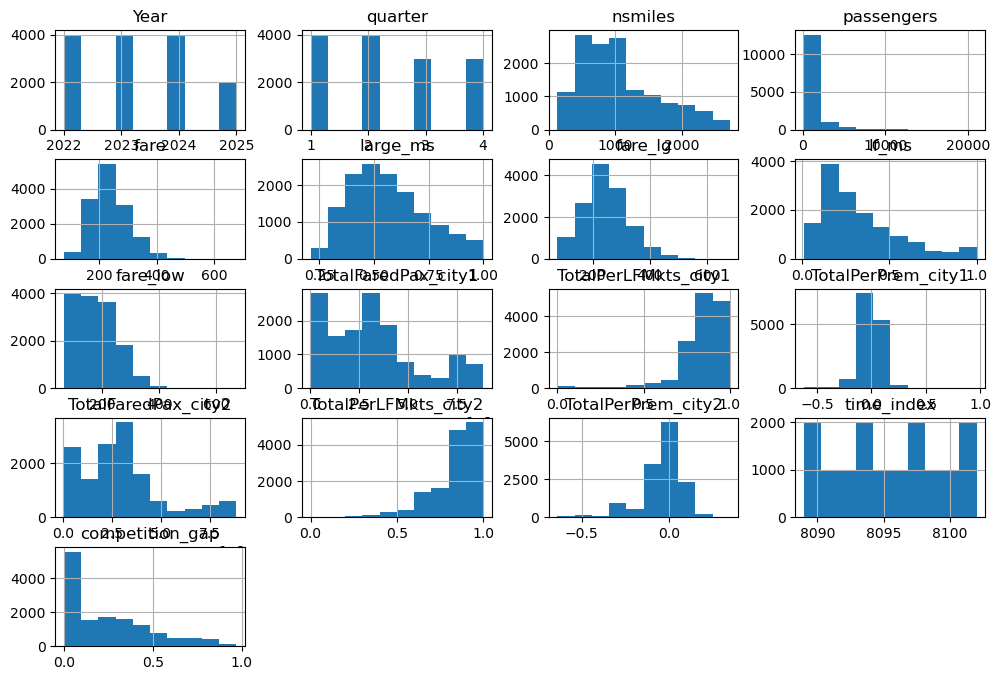

In [17]:
air.hist(figsize=(12,8))

### Distribution of Numerical Variables

Histograms show that several variables, particularly `passengers`, `fare`, and `nsmiles`, are right-skewed. 
This indicates the presence of extreme values and suggests that transformations may be helpful before modeling.

In [21]:
air['log_fare'] = np.log(air['fare'])
air['log_passengers'] = np.log(air['passengers'])
air['log_distance'] = np.log(air['nsmiles'])

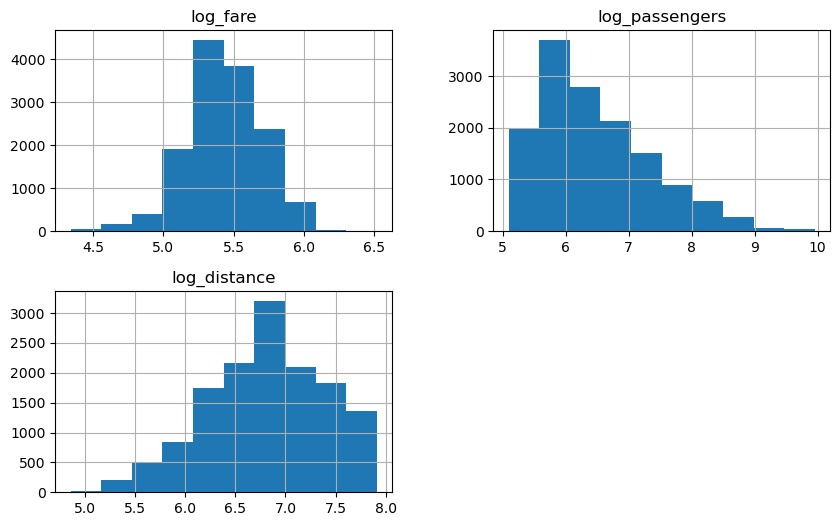

In [26]:
air[['log_fare','log_passengers','log_distance']].hist(figsize=(10,6))
plt.show()

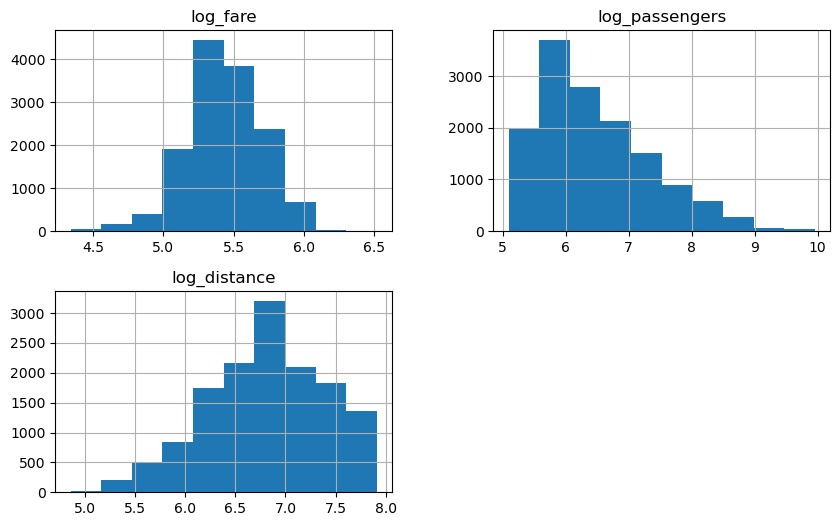

In [25]:
air[['log_fare','log_passengers','log_distance']].hist(figsize=(10,6))
plt.show()